# Домашнее задание №3

Задание присылать на обе почты почты aleksartamonov@gmail.com dashkov.alexander.om@gmail.com в виде ссылки на colab

В теме письма указать **CV_HSE_2021 HW3 <Фамилия Имя>**

soft deadline: 21.03.2021T23:59:00+0300

hard deadline: 28.03.2021T23:59:00+0300


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import ipywidgets as widgets
import os
from sklearn.cluster import KMeans, MiniBatchKMeans
import pandas as pd
from sklearn.model_selection import train_test_split

## Legacy классификация

**Задане 1 (10 баллов)**

Реализуйте функцию, которая строит банк фильтров Габора.
Реализуйте интерактивный инструмент, в котором с помощью 2-х ползунков, один из которых отвечает за угол, другой за масштаб для фильтров из банка, можно выбрать конкретный фильтр и на экране отобразятся:
- Фильтр в пространственной области
- Фильтр в частотном пространстве
- Результат применения этого фильтра к какому-нибудь изображению.

In [ ]:
def gabour_bank(size, phi_bins, scale_bins, max_scale, min_scale):
    """
    Parameters:
    size (tuple|int): Size or radius of filters.
    phi_bins (int): Number of angle beens of bank
    scale_bins (int): Number of scales betwwen max_scale and min_scale
    max_scale (float): Max frequency covered by bank
    min_scale (float): Min frequency covered by bank
    Returns:
    list: a list of filters
    """
    angles = np.linspace(0, np.pi, num=phi_bins, endpoint=False) 
    frequences = np.linspace(min_scale, max_scale, num=scale_bins)

    gabour_bank = np.empty(shape=(phi_bins, scale_bins, size, size))
    for i, angle in enumerate(angles):
        for j, freq in enumerate(frequences):
            gabour = cv2.getGaborKernel(ksize=(size, size), sigma=4, theta=angle, lambd=freq, gamma=0.5)
            gabour_bank[i, j] = gabour

    return gabour_bank


In [ ]:
def show_gabour(filter, fourier_filter, img, size=3):
    fig, ax = plt.subplots(1, 3, figsize=(4.5 * size, size))
    ax[0].set_title('Filter')
    ax[0].set_axis_off()
    ax[0].imshow(filter, cmap='gray')
    
    ax[1].set_title('Filter Fourier transform')
    ax[1].set_axis_off()
    ax[1].imshow(fourier_filter, cmap='gray')
    
    ax[2].set_title('Image filter application')
    ax[2].set_axis_off()
    img = cv2.filter2D(img, cv2.CV_8UC3, filter)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[2].imshow(img, cmap='gray')

def shift_fft(filter):
    filter = np.fft.fft2(filter)
    filter = np.abs(np.fft.fftshift(filter))
    filter = np.log(filter + 1e-10)

    return filter

In [ ]:
img = cv2.imread('zebry.jpg', 0)

size = 101
phi_bins = 50
scale_bins = 100
min_scale = 0.1
max_scale = 30


bank = gabour_bank(size, phi_bins, scale_bins, max_scale, min_scale)
angles = np.linspace(0, np.pi, num=phi_bins, endpoint=False) 
frequences = np.linspace(min_scale, max_scale, num=scale_bins)
indexes = {(str(angles[i]), str(frequences[j])): (i, j) for i in range(phi_bins) for j in range(scale_bins)}

@widgets.interact(lambd=widgets.SelectionSlider(options=frequences), angle=widgets.SelectionSlider(options=angles), )
def interact_gabour(lambd=frequences, angle=angles):
    i, j = indexes[(str(angle), str(lambd))]
    gabour = bank[i, j]
    fourier = shift_fft(gabour)
    show_gabour(gabour, fourier, img, size=4)

interactive(children=(SelectionSlider(description='lambd', options=(0.1, 0.40202020202020206, 0.70404040404040…

**Задание 2 (15 баллов)** 

Постройте мешок визульных слов на основе SIFT дескртипторов для датасета из третьего задания. Для этого для каждой картинки примените функцию, которая извлекает sift keypoints с дексрипторами, для каждой картинки ограничьтесь, например, сотней. Проведите кластеризацию на N(~30) классов, для каждого кластра отбразите в ряду 5 ближайших к нему участков изображений, в соответствии с масштабом keypoint-а. отобразите N таких строк.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install opencv-python-headless

In [2]:
!cp "/content/drive/MyDrive/Colab Notebooks/cv hw/hw3/sirius-traffic-lights-competition.zip" /content
!unzip -q sirius-traffic-lights-competition.zip

In [72]:
path = '/content/test/pic'
imgs = []

for img in os.listdir(path):
    imgs.append(cv2.imread(path + '/' + img))


In [73]:
def show(imgs, shape=None, size=3):
    imgs = imgs if isinstance(imgs, list) else [imgs]
    shape = (len(imgs), 1) if shape is None else shape
    rows, cols = shape
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))

    if rows == 1 or cols == 1:
        for ind, img in enumerate(imgs):
          plt.subplot(*shape, ind + 1)
        return

    item = 0
    for i in range(rows):
        for j in range(cols):  
            if item == len(imgs): 
                break
            ax[i][j].imshow(cv2.cvtColor(imgs[item], cv2.COLOR_BGR2RGB))
            ax[i][j].axis("off")
            item += 1
            

In [74]:
keypoints = []
descriptors = []
indices = []

sift = cv2.SIFT_create(100)

num_imgs = 3000
imgs = imgs[:num_imgs]

for i in range(num_imgs):
    img = cv2.cvtColor(imgs[i], cv2.COLOR_BGR2GRAY) 
    kp, desc = sift.detectAndCompute(img, None)
    
    for num in range(len(kp)):
        keypoints.append(kp[num])
        descriptors.append(desc[num])
        indices.append(i)

indices, keypoints, descriptors = map(np.array, [indices, keypoints, descriptors])

In [75]:
# clusterization

clust = KMeans(n_clusters=30).fit(descriptors)

In [76]:
def make_tile(img, x, y, rad):
  x, y = map(int, [x,y])
  img = img[y-rad : y+rad, x-rad:x+rad]
  return img


cluster_images = []
labels = np.unique(clust.labels_)
num_imgs_per_cluster = 100


# select 50 nearest points per cluster
for label in labels:
    mask = (clust.labels_ == label)
    ids = indices[mask]
    kp = keypoints[mask]
    desc = descriptors[mask] 
    clust_center = desc.mean(axis=0)

    dist = np.linalg.norm(desc - clust_center, axis=1)
    idx = np.argpartition(dist, num_imgs_per_cluster)[:num_imgs_per_cluster]

    # left 5 biggest of them
    kp = kp[idx]
    ids = ids[idx]
    size = [-keypoint.size for keypoint in kp]
    idx = np.argpartition(size, 5)[:5]

    # add data for plot
    for i in idx:
        keypoint = kp[i]
        x, y = map(np.round, keypoint.pt)
        rad = int(np.ceil(keypoint.size / 2) * 1.2)
        img = imgs[ids[i]]
        cluster_images.append(cv2.drawKeypoints(img, 
                                             [keypoint], 
                                             None, 
                                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

        img = cv2.warpAffine(img, 
                             cv2.getRotationMatrix2D((x,y), keypoint.angle, 1),
                             img.shape[:2][::-1],
                             flags=cv2.INTER_LINEAR)
        
        tile = make_tile(img, x, y, rad)
        cluster_images.append(tile)


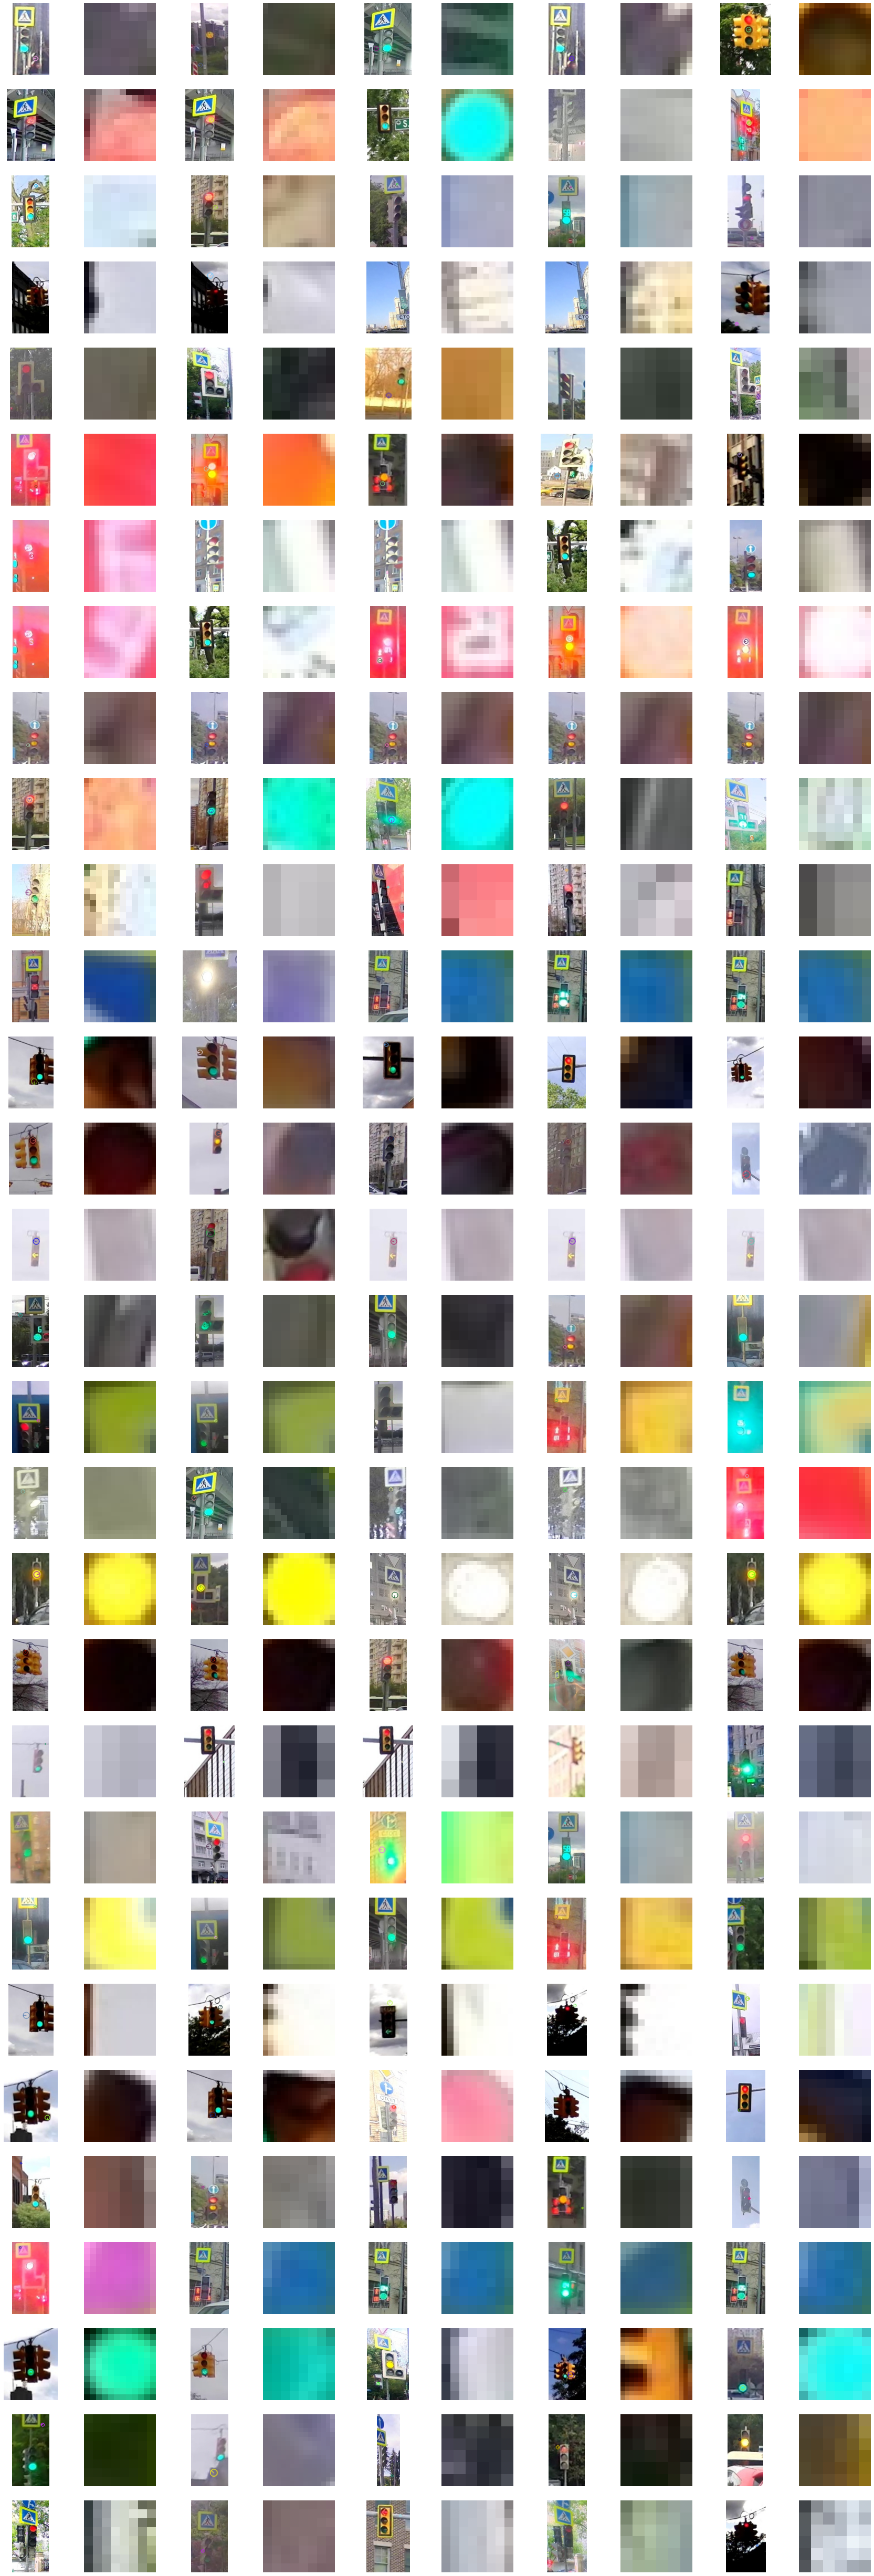

In [77]:
show(cluster_images, shape=(len(cluster_images) // 10, 10))

**Задание 3 (20 баллов)**

[КОНКУРС](https://youtu.be/8GGWedu77SA?t=3388)

В этом задании вам придется проявить изобретательность. Используйте банки фильтов, мешки визуальных слов и гистрограммы для достижения максимального скора. [Настоящая ссылка на конкурс](https://www.kaggle.com/t/65dc3b38e1194d488ab276752fd1e92d). В этом задании баллы будут распределяться согласно тому, как далеко вы продвинулись на лидерборде. **Важное условие**, весь ваш код положите в этот ноутбук, в нем не должно быть нейросетей =) Только legacy только *hard core*

Читаем данные для трейна

In [4]:
path = '/content/train_val/pic'
imgs = []
img_names = []
labels = []
y = pd.read_csv('/content/train_val/keys.csv')

for img in os.listdir(path):
    img_names.append(img)
    imgs.append(cv2.imread(path + '/' + img))
    labels.append(y[y['id'] == img[:-4]].category.values[0])

In [5]:
np.unique(labels, return_counts=True)

(array(['disabled', 'green', 'red', 'red_yellow', 'yellow'], dtype='<U10'),
 array([ 4588, 16060, 20650,  2041,  2294]))

Посчитаем гистограммы в rgb и hsv

In [10]:
def hist_rgb(img, bins):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bgr_planes = cv2.split(img)
    histRange=(0, 256)

    r_hist = cv2.calcHist(bgr_planes, [0], None, [bins[0]], histRange, accumulate=False)
    g_hist = cv2.calcHist(bgr_planes, [1], None, [bins[1]], histRange, accumulate=False)
    b_hist = cv2.calcHist(bgr_planes, [2], None, [bins[2]], histRange, accumulate=False)
    
    
    r_hist = cv2.normalize(r_hist, r_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    g_hist = cv2.normalize(g_hist, g_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    b_hist = cv2.normalize(b_hist, b_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    

    res = np.vstack([r_hist, g_hist, b_hist]).reshape(-1,)

    return res


# construct hsv hist
def hist_hsv(img, bins):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_planes = cv2.split(img)
    range0 = [0, 180]
    range1 = [0, 256]

    h_hist = cv2.calcHist(hsv_planes, [0], None, [bins[0]], range0, accumulate=False)
    s_hist = cv2.calcHist(hsv_planes, [1], None, [bins[1]], range1, accumulate=False)
    
    h_hist = cv2.normalize(h_hist, h_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    s_hist = cv2.normalize(s_hist, s_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    res = np.vstack([h_hist, s_hist]).reshape(-1,)
    return res

# make crops of image with grid  (x_cnt, y_cnt)
def make_crops(img, x_cnt, y_cnt):
    list_crops = []
    y, x, _ = img.shape

    y_step = y // y_cnt
    x_step = x // x_cnt

    for i in range(x_cnt):
        for j in range(y_cnt):
            list_crops.append(img[y_step * j : y_step * (j + 1), x_step * i : x_step * (i+1)]) 
            
    return list_crops

In [89]:
bins_rgb = [50, 50, 50]
bins_hsv = [50, 50]
X = []

for i, img in enumerate(imgs):
    hists = []
    rgb = hist_rgb(img, bins_rgb)
    hsv = hist_hsv(img, bins_hsv)
    hists = np.concatenate([hists, rgb, hsv])
    
    crops = make_crops(img, 3, 3)
    for crop in crops:
        rgb = hist_rgb(crop, bins_rgb)
        hsv = hist_hsv(crop, bins_hsv)
        hists = np.concatenate([hists, rgb, hsv])
    
    X.append(hists)

X = np.array(X)

In [90]:
y_raw = labels
X.shape

(45633, 2500)

In [7]:
!pip -q install catboost

     |████████████████████████████████| 67.3MB 151kB/s 


In [8]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [91]:
le = preprocessing.LabelEncoder()
le.fit(y_raw)
y = le.transform(y_raw)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

Обучение Catboost модели

In [94]:
train_dataset = Pool(data=X_train,
                     label=y_train)

eval_dataset = Pool(data=X_val,
                    label=y_val)

# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=3000,
                           early_stopping_rounds=10,
                           loss_function='MultiClass', 
                           auto_class_weights='Balanced',
                           eval_metric='Accuracy',
                           task_type="GPU",
                           devices='0:1')
# Fit model
model.fit(train_dataset)
# Get predicted classes
preds_class = model.predict(eval_dataset)

Learning rate set to 0.055462
0:	learn: 0.4666530	total: 190ms	remaining: 9m 28s
1:	learn: 0.5014570	total: 295ms	remaining: 7m 21s
2:	learn: 0.5246903	total: 397ms	remaining: 6m 36s
3:	learn: 0.5317241	total: 481ms	remaining: 6m
4:	learn: 0.5385056	total: 565ms	remaining: 5m 38s
5:	learn: 0.5427497	total: 656ms	remaining: 5m 27s
6:	learn: 0.5454290	total: 744ms	remaining: 5m 18s
7:	learn: 0.5521286	total: 830ms	remaining: 5m 10s
8:	learn: 0.5572339	total: 917ms	remaining: 5m 4s
9:	learn: 0.5635338	total: 1s	remaining: 4m 59s
10:	learn: 0.5640679	total: 1.09s	remaining: 4m 55s
11:	learn: 0.5668287	total: 1.18s	remaining: 4m 52s
12:	learn: 0.5696732	total: 1.26s	remaining: 4m 49s
13:	learn: 0.5723982	total: 1.35s	remaining: 4m 47s
14:	learn: 0.5753847	total: 1.43s	remaining: 4m 45s
15:	learn: 0.5799033	total: 1.52s	remaining: 4m 43s
16:	learn: 0.5829968	total: 1.61s	remaining: 4m 42s
17:	learn: 0.5886441	total: 1.69s	remaining: 4m 40s
18:	learn: 0.5910074	total: 1.78s	remaining: 4m 39s


In [95]:
accuracy_score(preds_class, y_val)

0.8726993865030674

Предсказания на тесте

In [75]:
path = '/content/test/pic'
test_imgs = []
test_img_names = []

for img in os.listdir(path):
    test_img_names.append(img)
    test_imgs.append(cv2.imread(path + '/' + img))

In [76]:
bins_rgb = [50, 50, 50]
bins_hsv = [50, 50]
X_test = []

for i, img in enumerate(test_imgs):
    hists = []
    rgb = hist_rgb(img, bins_rgb)
    hsv = hist_hsv(img, bins_hsv)
    hists = np.concatenate([hists, rgb, hsv])
    
    crops = make_crops(img, 3, 3)
    for crop in crops:
        rgb = hist_rgb(crop, bins_rgb)
        hsv = hist_hsv(crop, bins_hsv)
        hists = np.concatenate([hists, rgb, hsv])
    
    X_test.append(hists)

X_test = np.array(X_test)

In [77]:
preds = model.predict(X_test)
preds = list(le.inverse_transform(preds.reshape(-1)))
submission = pd.DataFrame()
submission['id'] = [img[:-4] for img in test_img_names]
submission['category'] = preds
submission.to_csv('submit8.csv', index=False)
submission.head()

id category
0  pic005088    green
1  pic002178      red
2  pic001938    green
3  pic007718    green
4  pic004101      red